In [27]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
device

device(type='cuda')

In [17]:
!nvidia-smi

Wed Feb 16 15:15:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    35W / 250W |   1065MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
batch_size = 64
num_classes = 10

### Loading the Dataset
Using torchvision , we will load the dataset as this will allow us to perform any pre-processing steps easily.

In [19]:
class LeNet5(nn.Module):
    def __init__(self,num_classes):
        super(LeNet5,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=(0,0)), #Layer 1
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2)) #Layer-2
        )                
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=(1,1), padding=(0,0)), #Layer 3
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2)) #Layer 4
        )
        self.fc = nn.Linear(400, 120) # Layer 5
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84) # Layer 6
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes) # Final Layer
        
    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        # print('output after layer2', output.size()) # torch.Size([32, 16, 5, 5]
        output = output.reshape(output.size(0), -1) # See note below for this line
        # print('output after resize', output.size()) # torch.Size([32, 400])
        output = self.fc(output)
        output = self.relu(output)
        output = self.fc1(output)
        output = self.relu1(output)
        output = self.fc2(output)
        return output
        

In [20]:
# Define relevant variables for the ML task

''' Keeping num_classes at 10, as this will be the output shape from the final Layer of the LeNet5 Neural Network model, because, the output layer will have 10 output neurons, since the MNIST data has 10 classes for each of the 10 numerical digits. '''

train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

## Build the architecture of LeNet5 from Scratch

In [21]:
learning_rate = 0.001

model = LeNet5(num_classes).to(device)

#Setting the loss function
criterion = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_dataloader)

In [22]:
print('Length of train_dataloader ', len(train_dataloader))
print('Length of test_dataloader ', len(test_dataloader))

Length of train_dataloader  938
Length of test_dataloader  157


## Setting Hyperparameters


In [23]:
def train(model, criterion, optimizer, num_epochs=10):
    total_training_loss = []
    total_step = len(train_dataloader)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for i, (images, labels) in enumerate(train_dataloader):  
            images = images.to(device)
            labels = labels.to(device)
            
            #Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
                
            # Backward and optimize
            optimizer.zero_grad() # Clear the past gradient by set the gradients to zero before every update
            loss.backward() #  calculate the new gradients
            # print('images.size ', images.size(0))
            running_loss += loss.item() * images.size(0)
            optimizer.step() # we update the weights 
            
                
            if (i+1) % 400 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                            .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        epoch_loss = running_loss / len(train_dataloader)
        total_training_loss.append(epoch_loss)
    return total_training_loss  
    
  

In [24]:
total_training_loss = train(model, criterion, optimizer, num_epochs=30)

Epoch [1/30], Step [400/938], Loss: 0.0270
Epoch [1/30], Step [800/938], Loss: 0.1064
Epoch [2/30], Step [400/938], Loss: 0.0322
Epoch [2/30], Step [800/938], Loss: 0.0453
Epoch [3/30], Step [400/938], Loss: 0.0066
Epoch [3/30], Step [800/938], Loss: 0.0386
Epoch [4/30], Step [400/938], Loss: 0.0346
Epoch [4/30], Step [800/938], Loss: 0.0306
Epoch [5/30], Step [400/938], Loss: 0.0016
Epoch [5/30], Step [800/938], Loss: 0.0295
Epoch [6/30], Step [400/938], Loss: 0.0009
Epoch [6/30], Step [800/938], Loss: 0.0145
Epoch [7/30], Step [400/938], Loss: 0.0020
Epoch [7/30], Step [800/938], Loss: 0.0363
Epoch [8/30], Step [400/938], Loss: 0.0061
Epoch [8/30], Step [800/938], Loss: 0.0026
Epoch [9/30], Step [400/938], Loss: 0.0335
Epoch [9/30], Step [800/938], Loss: 0.0120
Epoch [10/30], Step [400/938], Loss: 0.0395
Epoch [10/30], Step [800/938], Loss: 0.0007
Epoch [11/30], Step [400/938], Loss: 0.0007
Epoch [11/30], Step [800/938], Loss: 0.0060
Epoch [12/30], Step [400/938], Loss: 0.0012
Epoch 

In [25]:
total_training_loss

[10.568266467943882,
 3.527540081909407,
 2.6088559687145545,
 2.1823721174309565,
 1.924547830021688,
 1.6057489041481285,
 1.3537017107074425,
 1.1566425667095708,
 1.1153176984784983,
 0.983036599652807,
 0.8899051300895366,
 0.6929740591073604,
 0.7318501428482301,
 0.7322920497585915,
 0.4553440813554328,
 0.6452689993842532,
 0.5951177723426396,
 0.46549444908607823,
 0.48881708133601715,
 0.4589629755210131,
 0.40898956688392407,
 0.433147037635138,
 0.3640874308061105,
 0.3657881085964735,
 0.3087785066473603,
 0.3707788242852709,
 0.24622227986580741,
 0.282929215015277,
 0.3211896866044501,
 0.24679545621306762]

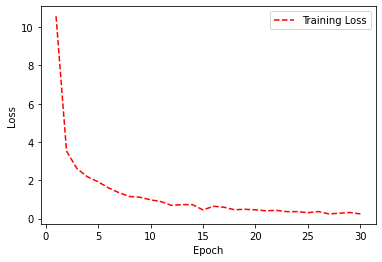

In [28]:

epoch_count = range(1, len(total_training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, total_training_loss, 'r--')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();